In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.io import mmread
from scipy.sparse import csr_matrix
import pickle as pkl
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

import gc

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
#import seaborn as sns

import scib_metrics as sm
import sys
import os
sys.path.append('/'.join(os.getcwd().split('/')[:-1]+['eval','cleaned','']))
#from metrics import ilisi,asw_batch

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

# Define the path to the directory you want to change to
new_directory = '/scratch365/eaboelno/cVAE_analysis/sysVI/'

# Use os.chdir() to change the working directory
os.chdir(new_directory)

# Find shared genes and concat

In [2]:
mdata = sc.read_h5ad("./mdata_cellrang_6KHVG.h5ad")
mdata

AnnData object with n_obs × n_vars = 321566 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts'
    var: 'human_gene_id', 'n_cells', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [3]:
adata_mm = sc.read_h5ad('./adata_mm_merged_cr6kHVG.h5ad')
adata_mm

AnnData object with n_obs × n_vars = 112017 × 6000
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'mouse_gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    layers: 'counts', 'log1p_norm'

In [4]:
print(adata_mm.X[:10, :10])

  (0, 7)	0.85185707
  (0, 4)	1.1039293
  (0, 3)	0.51401925
  (1, 4)	1.1123087
  (1, 3)	0.519066
  (2, 7)	1.6199739
  (2, 4)	1.1074
  (3, 7)	1.7579904
  (3, 5)	0.8635851
  (3, 4)	1.3199666
  (4, 7)	1.3365874
  (4, 4)	0.53151506
  (4, 3)	1.7767402
  (4, 2)	0.53151506
  (5, 8)	0.5346283
  (5, 7)	1.7830038
  (5, 4)	1.1379743
  (6, 7)	1.5179869
  (6, 4)	0.5380162
  (7, 7)	1.5274038
  (7, 4)	1.5274038
  (8, 7)	1.3728527
  (8, 4)	1.3728527
  (9, 7)	1.3973262
  (9, 4)	1.1888425
  (9, 3)	0.5659346
  (9, 1)	0.5659346


In [5]:
print(mdata.X[:10, :10])

  (3, 0)	2.1317280276818393
  (2, 6)	1.537505303406224
  (6, 6)	1.2002639505735508
  (8, 6)	2.372822326128577


In [6]:
print(adata_mm.raw.X[:10, :10])

  (0, 5)	1
  (3, 8)	1
  (3, 5)	2
  (3, 3)	1
  (4, 5)	1
  (5, 8)	2
  (5, 5)	3
  (5, 4)	1
  (5, 2)	1
  (6, 5)	1
  (8, 5)	2
  (9, 5)	6


In [7]:
print(mdata.raw.X[:10, :10])

  (2, 7)	2.0
  (6, 7)	2.0


In [8]:
# Check the dimensions of mdata.X
print("Dimensions of adata_mm.X:", adata_mm.X.shape)

# Check the dimensions of mdata.raw
print("Dimensions of adata_mm.raw:", adata_mm.raw.X.shape)

Dimensions of adata_mm.X: (112017, 6000)
Dimensions of adata_mm.raw: (112017, 23660)


In [9]:
# Check the dimensions of mdata.X
print("Dimensions of mdata.X:", mdata.X.shape)

# Check the dimensions of mdata.raw
print("Dimensions of mdata.raw:", mdata.raw.X.shape)

Dimensions of mdata.X: (321566, 6000)
Dimensions of mdata.raw: (321566, 30936)


# Reset var names for human/mouse merging

In [10]:
mdata.var

,human_gene_id,n_cells,mouse_gene_id,mouse_gene_name,human_gene_name,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
LINC02593,ENSG00000223764,1064,NaN,NaN,LINC02593,1087,0.003554,99.676193,1193.0,True,0.003766,1.087351,0.441182,28,False
SAMD11,ENSG00000187634,4516,ENSMUSG00000096351,Samd11,SAMD11,4620,0.020438,98.623747,6861.0,True,0.015412,1.261997,0.650810,34,False
HES4,ENSG00000188290,12241,NaN,NaN,HES4,14105,0.098667,95.798257,33122.0,True,0.032598,1.431164,1.131118,52,False
ISG15,ENSG00000187608,8167,ENSMUSG00000035692,Isg15,ISG15,9071,0.045670,97.297837,15331.0,True,0.025319,1.344263,0.486557,35,False
TNFRSF18,ENSG00000186891,1318,ENSMUSG00000041954,Tnfrsf18,TNFRSF18,1609,0.005734,99.520694,1925.0,True,0.002810,1.140190,0.468671,32,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,ENSG00000212907,110217,ENSMUSG00000065947,mt-Nd4l,MT-ND4L,122199,1.048264,63.598098,351896.0,True,0.697807,1.182034,0.575813,38,False
MT-ND4,ENSG00000198886,208035,ENSMUSG00000064363,mt-Nd4,MT-ND4,222026,9.526474,33.860599,3197980.0,True,2.120134,0.914840,-0.819017,30,False
MT-ND5,ENSG00000198786,131820,ENSMUSG00000064367,mt-Nd5,MT-ND5,144526,1.778712,56.947101,597103.0,True,0.872898,1.221021,1.040633,38,False
MT-ND6,ENSG00000198695,13367,ENSMUSG00000064368,mt-Nd6,MT-ND6,15114,0.055834,95.497685,18743.0,True,0.042749,1.370388,0.645717,27,False


In [11]:
adata_mm.var

,mouse_gene_id,mouse_gene_name,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
gene_name,,,,,,,,
0610040J01Rik,ENSMUSG00000060512,0610040J01Rik,True,0.180765,1.387009,2.088852,26,False
0610043K17Rik,ENSMUSG00000087361,0610043K17Rik,True,0.067873,1.425384,1.228217,23,False
1110017D15Rik,ENSMUSG00000028441,1110017D15Rik,True,0.022708,1.426803,1.080782,19,False
1110019D14Rik,ENSMUSG00000097616,1110019D14Rik,True,0.071954,1.283477,0.596595,12,False
1110051M20Rik,ENSMUSG00000040591,1110051M20Rik,True,0.325273,1.154913,0.777810,15,False
...,...,...,...,...,...,...,...,...
Zswim4,ENSMUSG00000035671,Zswim4,True,0.094655,1.284577,1.095245,19,False
Zswim5,ENSMUSG00000033948,Zswim5,True,0.104244,1.365441,1.461120,20,False
Zswim6,ENSMUSG00000032846,Zswim6,True,0.732671,1.097387,0.778180,21,False


In [12]:
adata_mm.var_names = adata_mm.var_names.map(lambda x: x.upper())
adata_mm.var

,mouse_gene_id,mouse_gene_name,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
gene_name,,,,,,,,
0610040J01RIK,ENSMUSG00000060512,0610040J01Rik,True,0.180765,1.387009,2.088852,26,False
0610043K17RIK,ENSMUSG00000087361,0610043K17Rik,True,0.067873,1.425384,1.228217,23,False
1110017D15RIK,ENSMUSG00000028441,1110017D15Rik,True,0.022708,1.426803,1.080782,19,False
1110019D14RIK,ENSMUSG00000097616,1110019D14Rik,True,0.071954,1.283477,0.596595,12,False
1110051M20RIK,ENSMUSG00000040591,1110051M20Rik,True,0.325273,1.154913,0.777810,15,False
...,...,...,...,...,...,...,...,...
ZSWIM4,ENSMUSG00000035671,Zswim4,True,0.094655,1.284577,1.095245,19,False
ZSWIM5,ENSMUSG00000033948,Zswim5,True,0.104244,1.365441,1.461120,20,False
ZSWIM6,ENSMUSG00000032846,Zswim6,True,0.732671,1.097387,0.778180,21,False


In [13]:
# Get gene names from each data frame
genes_adata_mm = set(adata_mm.var_names)
genes_mdata_h2m = set(mdata.var_names)

# Find the intersection of genes among the data frames
intersecting_genes = genes_adata_mm.intersection(genes_mdata_h2m)

# Print the number of intersecting genes
print("Number of intersecting genes:", len(intersecting_genes))

Number of intersecting genes: 2904


In [14]:
# Shared HVGs
shared_hvgs=list(set(adata_mm.var_names) & set(mdata.var_names))
len(shared_hvgs)

2904

In [15]:
# Subset to shraed HVGs and concat
# Keys adds a category annotation to each observation (row)
adata_all=sc.concat([adata_mm[:,shared_hvgs], mdata[:,shared_hvgs]],
                join='outer',
                index_unique='_', keys=['mouse', 'macnair'])
adata_all

AnnData object with n_obs × n_vars = 433583 × 2904
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts'
    layers: 'counts', 'log1p_norm'

In [16]:
print(adata_all.raw.X[:10, :10])

  (0, 5)	1.0
  (3, 3)	1.0
  (3, 5)	2.0
  (3, 8)	1.0
  (4, 5)	1.0
  (5, 2)	1.0
  (5, 4)	1.0
  (5, 5)	3.0
  (5, 8)	2.0
  (6, 5)	1.0
  (8, 5)	2.0
  (9, 5)	6.0


In [17]:
print(adata_all.X[:10, :10])

  (0, 0)	0.514019250869751
  (0, 1)	0.514019250869751
  (0, 2)	1.9527411460876465
  (0, 4)	2.5723040103912354
  (0, 7)	0.514019250869751
  (0, 8)	0.514019250869751
  (1, 0)	0.8590490818023682
  (1, 1)	1.1123087406158447
  (1, 4)	2.215445041656494
  (1, 8)	0.5190659761428833
  (2, 0)	0.8548349142074585
  (2, 1)	1.476469874382019
  (2, 2)	2.80556058883667
  (2, 4)	2.7203314304351807
  (3, 1)	1.3199665546417236
  (3, 2)	2.6889679431915283
  (3, 4)	1.8697373867034912
  (3, 7)	0.522254467010498
  (4, 1)	0.8767248392105103
  (4, 2)	0.8767248392105103
  (4, 4)	1.5057518482208252
  (4, 5)	0.5315150618553162
  (4, 8)	0.8767248392105103
  (5, 0)	0.5346282720565796
  (5, 1)	0.5346282720565796
  (5, 2)	2.2493703365325928
  (5, 4)	2.6190474033355713
  (6, 0)	0.5380162000656128
  (6, 2)	2.855891704559326
  (6, 4)	1.7897979021072388
  (6, 8)	0.5380162000656128
  (7, 1)	0.5430452823638916
  (7, 2)	1.7998406887054443
  (7, 4)	2.0137243270874023
  (7, 7)	0.5430452823638916
  (8, 0)	0.5519569516181946
  

In [18]:
def add_years(value):
    if isinstance(value, int):  # Check if the value is an integer
        return str(value) + ' years'  # Convert integer to string and add ' years'
    elif isinstance(value, str) and value.isdigit():  # Check if the value is a string containing only digits
        return value + ' years'
    else:
        return value

# Apply the function to the "time" column in adata_all.obs
adata_all.obs['time'] = adata_all.obs['time'].apply(add_years)

In [19]:
adata_all.obs['batch'] = adata_all.obs['batch'].astype(str)

In [20]:
adata_all.obs['exclude_pseudobulk'] = adata_all.obs['exclude_pseudobulk'].astype(str)

In [21]:
adata_all.obs['age_at_death'] = adata_all.obs['age_at_death'].astype(str)

In [22]:
adata_all.obs['age_scale'] = adata_all.obs['age_scale'].astype(str)

In [23]:
mdata.var

,human_gene_id,n_cells,mouse_gene_id,mouse_gene_name,human_gene_name,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
LINC02593,ENSG00000223764,1064,NaN,NaN,LINC02593,1087,0.003554,99.676193,1193.0,True,0.003766,1.087351,0.441182,28,False
SAMD11,ENSG00000187634,4516,ENSMUSG00000096351,Samd11,SAMD11,4620,0.020438,98.623747,6861.0,True,0.015412,1.261997,0.650810,34,False
HES4,ENSG00000188290,12241,NaN,NaN,HES4,14105,0.098667,95.798257,33122.0,True,0.032598,1.431164,1.131118,52,False
ISG15,ENSG00000187608,8167,ENSMUSG00000035692,Isg15,ISG15,9071,0.045670,97.297837,15331.0,True,0.025319,1.344263,0.486557,35,False
TNFRSF18,ENSG00000186891,1318,ENSMUSG00000041954,Tnfrsf18,TNFRSF18,1609,0.005734,99.520694,1925.0,True,0.002810,1.140190,0.468671,32,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,ENSG00000212907,110217,ENSMUSG00000065947,mt-Nd4l,MT-ND4L,122199,1.048264,63.598098,351896.0,True,0.697807,1.182034,0.575813,38,False
MT-ND4,ENSG00000198886,208035,ENSMUSG00000064363,mt-Nd4,MT-ND4,222026,9.526474,33.860599,3197980.0,True,2.120134,0.914840,-0.819017,30,False
MT-ND5,ENSG00000198786,131820,ENSMUSG00000064367,mt-Nd5,MT-ND5,144526,1.778712,56.947101,597103.0,True,0.872898,1.221021,1.040633,38,False
MT-ND6,ENSG00000198695,13367,ENSMUSG00000064368,mt-Nd6,MT-ND6,15114,0.055834,95.497685,18743.0,True,0.042749,1.370388,0.645717,27,False


In [25]:
mapper_dict = dict(zip(mdata.var.index, mdata.var['human_gene_id']))

# 2. Use the mapper to add 'human_gene_id' to adata_all
adata_all.var['human_gene_id'] = adata_all.var_names.map(mapper_dict)

In [26]:
adata_all.var

,human_gene_id
SNX24,ENSG00000064652
FAM49A,ENSG00000197872
KHDRBS3,ENSG00000131773
MSR1,ENSG00000038945
CACNA1D,ENSG00000157388
...,...
TEAD1,ENSG00000187079
KCNK1,ENSG00000135750
SYNPO2,ENSG00000172403
SDK2,ENSG00000069188


In [27]:
mapper_dict = dict(zip(mdata.var.index, mdata.var['mouse_gene_id']))

# 2. Use the mapper to add 'human_gene_id' to adata_all
adata_all.var['mouse_gene_id'] = adata_all.var_names.map(mapper_dict)
adata_all.var

,human_gene_id,mouse_gene_id
SNX24,ENSG00000064652,ENSMUSG00000024535
FAM49A,ENSG00000197872,ENSMUSG00000020589
KHDRBS3,ENSG00000131773,ENSMUSG00000022332
MSR1,ENSG00000038945,ENSMUSG00000025044
CACNA1D,ENSG00000157388,ENSMUSG00000015968
...,...,...
TEAD1,ENSG00000187079,ENSMUSG00000055320
KCNK1,ENSG00000135750,ENSMUSG00000033998
SYNPO2,ENSG00000172403,ENSMUSG00000050315
SDK2,ENSG00000069188,ENSMUSG00000041592


In [28]:
mapper_dict = dict(zip(mdata.var.index, mdata.var['mouse_gene_name']))

# 2. Use the mapper to add 'human_gene_id' to adata_all
adata_all.var['mouse_gene_name'] = adata_all.var_names.map(mapper_dict)
adata_all.var

,human_gene_id,mouse_gene_id,mouse_gene_name
SNX24,ENSG00000064652,ENSMUSG00000024535,Snx24
FAM49A,ENSG00000197872,ENSMUSG00000020589,NaN
KHDRBS3,ENSG00000131773,ENSMUSG00000022332,Khdrbs3
MSR1,ENSG00000038945,ENSMUSG00000025044,Msr1
CACNA1D,ENSG00000157388,ENSMUSG00000015968,Cacna1d
...,...,...,...
TEAD1,ENSG00000187079,ENSMUSG00000055320,Tead1
KCNK1,ENSG00000135750,ENSMUSG00000033998,Kcnk1
SYNPO2,ENSG00000172403,ENSMUSG00000050315,Synpo2
SDK2,ENSG00000069188,ENSMUSG00000041592,Sdk2


In [29]:
adata_all.var['human_gene_name'] = adata_all.var_names
adata_all.var

,human_gene_id,mouse_gene_id,mouse_gene_name,human_gene_name
SNX24,ENSG00000064652,ENSMUSG00000024535,Snx24,SNX24
FAM49A,ENSG00000197872,ENSMUSG00000020589,NaN,FAM49A
KHDRBS3,ENSG00000131773,ENSMUSG00000022332,Khdrbs3,KHDRBS3
MSR1,ENSG00000038945,ENSMUSG00000025044,Msr1,MSR1
CACNA1D,ENSG00000157388,ENSMUSG00000015968,Cacna1d,CACNA1D
...,...,...,...,...
TEAD1,ENSG00000187079,ENSMUSG00000055320,Tead1,TEAD1
KCNK1,ENSG00000135750,ENSMUSG00000033998,Kcnk1,KCNK1
SYNPO2,ENSG00000172403,ENSMUSG00000050315,Synpo2,SYNPO2
SDK2,ENSG00000069188,ENSMUSG00000041592,Sdk2,SDK2


In [30]:
var_dtype = adata_all.var.dtypes

print("Data type of each column in adata_all.var:")
print(var_dtype)

Data type of each column in adata_all.var:
human_gene_id      object
mouse_gene_id      object
mouse_gene_name    object
human_gene_name    object
dtype: object


In [31]:
var_indices = adata_all.var.index

print("Content of indices in adata_all.var:")
print(var_indices)

Content of indices in adata_all.var:
Index(['SNX24', 'FAM49A', 'KHDRBS3', 'MSR1', 'CACNA1D', 'CDYL', 'CPM', 'PTPN2',
       'STK38L', 'TBC1D10C',
       ...
       'GPNMB', 'FOLH1', 'LMO4', 'PRKX', 'CLSTN2', 'TEAD1', 'KCNK1', 'SYNPO2',
       'SDK2', 'IGSF21'],
      dtype='object', length=2904)


In [32]:
adata_all.write_h5ad('./adata_all_mergedHVG_CAPS.h5ad')

In [33]:
adata_all

AnnData object with n_obs × n_vars = 433583 × 2904
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts'
    var: 'human_gene_id', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name'
    layers: 'counts', 'log1p_norm'

# Crosstable plots

In [34]:
adata_all.obs

,sample_id,publication,sample_id_anon,individual_id_anon,replicate,treatment,condition,tissue,time,batch,lesion_type,sample_source,diagnosis,n_genes_by_counts,total_counts,pct_counts_mt,pct_counts_ribo,s_score,g2m_score,phase,type_fine,type_broad,cluster_zoom,exclude_pseudobulk,seq_pool,sex,age_at_death,smoker,cause_of_death,years_w_ms,pmi_minutes,age_scale,age_cat,pmi_cat,pmi_cat2,cell_cycle_diff,cell_type_eval,library_type,sample_type,organism,system,n_counts
GTATTTCGTCCACATA-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,3806.0,14894.0,0.013428,0.093998,-0.160523,-0.120577,G1,TBD,excitatory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,-0.039946,excitatory neurons,10X 3p kit v3.1,sn,mouse,0,NaN
ATACCTTGTCGACGCT-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,3755.0,14716.0,0.000000,0.176678,-0.137565,-0.107280,G1,TBD,inhibitory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,-0.030285,inhibitory neurons,10X 3p kit v3.1,sn,mouse,0,NaN
TCAAGACGTGCTGCAC-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,4396.0,14823.0,0.026985,0.155164,-0.147916,-0.150035,G1,TBD,excitatory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,0.002119,excitatory neurons,10X 3p kit v3.1,sn,mouse,0,NaN
AGTACTGTCAAGTAAG-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,4583.0,14604.0,0.020542,0.212271,-0.132352,-0.172023,G1,TBD,excitatory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,0.039672,excitatory neurons,10X 3p kit v3.1,sn,mouse,0,NaN
TCCCAGTTCCGATGCG-1_adams_mouse,cl2,(this study),adams_Sample6_2,adams_Sample6,2,LPC,Demyelination,Corpus callosum,7dpl,6,Demyelination,(this study),Demyelination,3839.0,14266.0,0.028039,0.203281,-0.134222,-0.118009,G1,TBD,inhibitory neurons,TBD,False,None,mixed,1,non-smoker,sacrificed,0.0,0.0,0,adult,None,None,-0.016213,inhibitory neurons,10X 3p kit v3.1,sn,mouse,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ind102-Sample4:TTTGTTGAGCGACTGA-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,CAL,Amsterdam BB,SPMS,842.0,1227.0,5.207486,0.437056,0.006362,-0.053391,S,Oligo_B,Oligodendrocytes,oligo_opc-cl01,False,Pool 1,M,64,non-smoker,terminal phase ms; spastic ms,34.0,450.0,0.301502181578831,inbetween,6H_to_12H,up_to_12H,0.059753,oligodendrocytes,10X 3p kit v3.3,sn,human,1,1227.0
Ind102-Sample4:TTTGTTGAGTAGCTCT-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,CAL,Amsterdam BB,SPMS,641.0,1060.0,7.627119,0.139768,-0.048246,-0.086150,G1,Micro_C,Microglia,microglia-cl03,False,Pool 1,M,64,non-smoker,terminal phase ms; spastic ms,34.0,450.0,0.301502181578831,inbetween,6H_to_12H,up_to_12H,0.037903,microglia,10X 3p kit v3.3,sn,human,1,1060.0
Ind102-Sample4:TTTGTTGCAGACGATG-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,CAL,Amsterdam BB,SPMS,580.0,820.0,7.299270,0.322318,-0.084481,-0.032177,G1,Micro_B,Microglia,microglia-cl02,False,Pool 1,M,64,non-smoker,terminal phase ms; spastic ms,34.0,450.0,0.301502181578831,inbetween,6H_to_12H,up_to_12H,-0.052304,microglia,10X 3p kit v3.3,sn,human,1,820.0
Ind102-Sample4:TTTGTTGCATACAGAA-1_macnair,Human_MS,Macnair et al. biorxiv,Ind102-Sample4,Ind102,1,MS_patient,MS,White matter,64 years,122,CAL,Amsterdam BB,SPMS,1146.0,1899.0,5.891636,0.383352,0.025758,0.049047,G2M,Oligo_E,Oligodendrocytes,

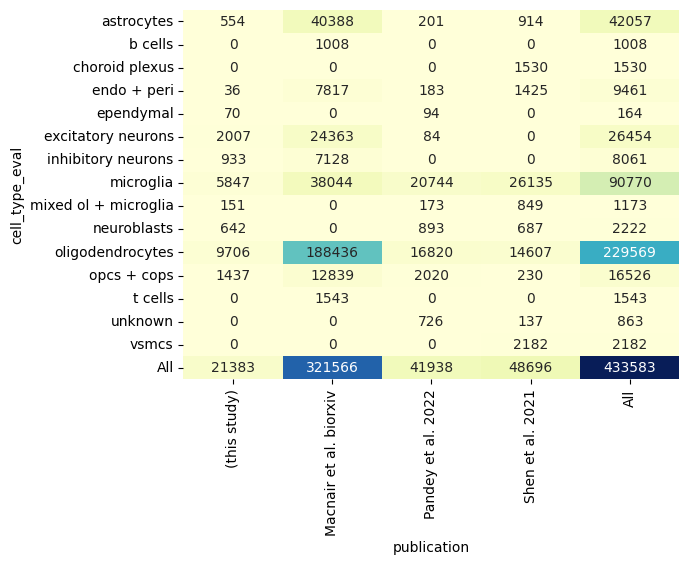

In [35]:
crosstab_df = pd.crosstab(adata_all.obs.cell_type_eval, adata_all.obs.publication, margins=True)

# Create the heatmap with integer annotations
sb.heatmap(crosstab_df, cmap="YlGnBu", annot=True, fmt="d", cbar=False)

# Show the heatmap
plt.show()

In [36]:
system_counts = adata_all.obs['system'].value_counts()

# Create a DataFrame to display the counts
system_counts_df = pd.DataFrame({'System': system_counts.index, 'Count': system_counts.values})
system_counts_df

,System,Count
0,1,321566
1,0,112017
